In [1]:
import os

os.chdir("..")
%load_ext autoreload

%autoreload 2
from src.transforms.generate import (
    CustomMotion,
    Preprocess,
    CreateSynthVolume,
    FinalCrop,
    get_matrices,
    get_motion_dist,
    get_affine,
)
from src.transforms.load import ToSoftLabel
import matplotlib.pyplot as plt
import torchio as tio
from torchio.transforms import RandomElasticDeformation
from torchvision.transforms import ToPILImage
from monai.transforms.intensity.array import ScaleIntensity
from monai.transforms import RandomizableTransform, CutMix
from monai.losses.ssim_loss import SSIMLoss
from torchio import Subject
import seaborn as sb
import numpy as np
import torch
import pandas as pd
from monai.transforms import (
    Compose,
    LoadImaged,
    Orientationd,
    ScaleIntensityd,
    CenterSpatialCropd,
    RandomizableTransform,
)
from torchio.transforms import (
    RandomElasticDeformation,
    RandomGamma,
    RandomFlip,
    RandomBiasField,
    RandomMotion
)
from monai.data.meta_tensor import MetaTensor
import torchvision.transforms.v2 as v2

c:\Users\Brico\miniconda3\envs\bowl\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


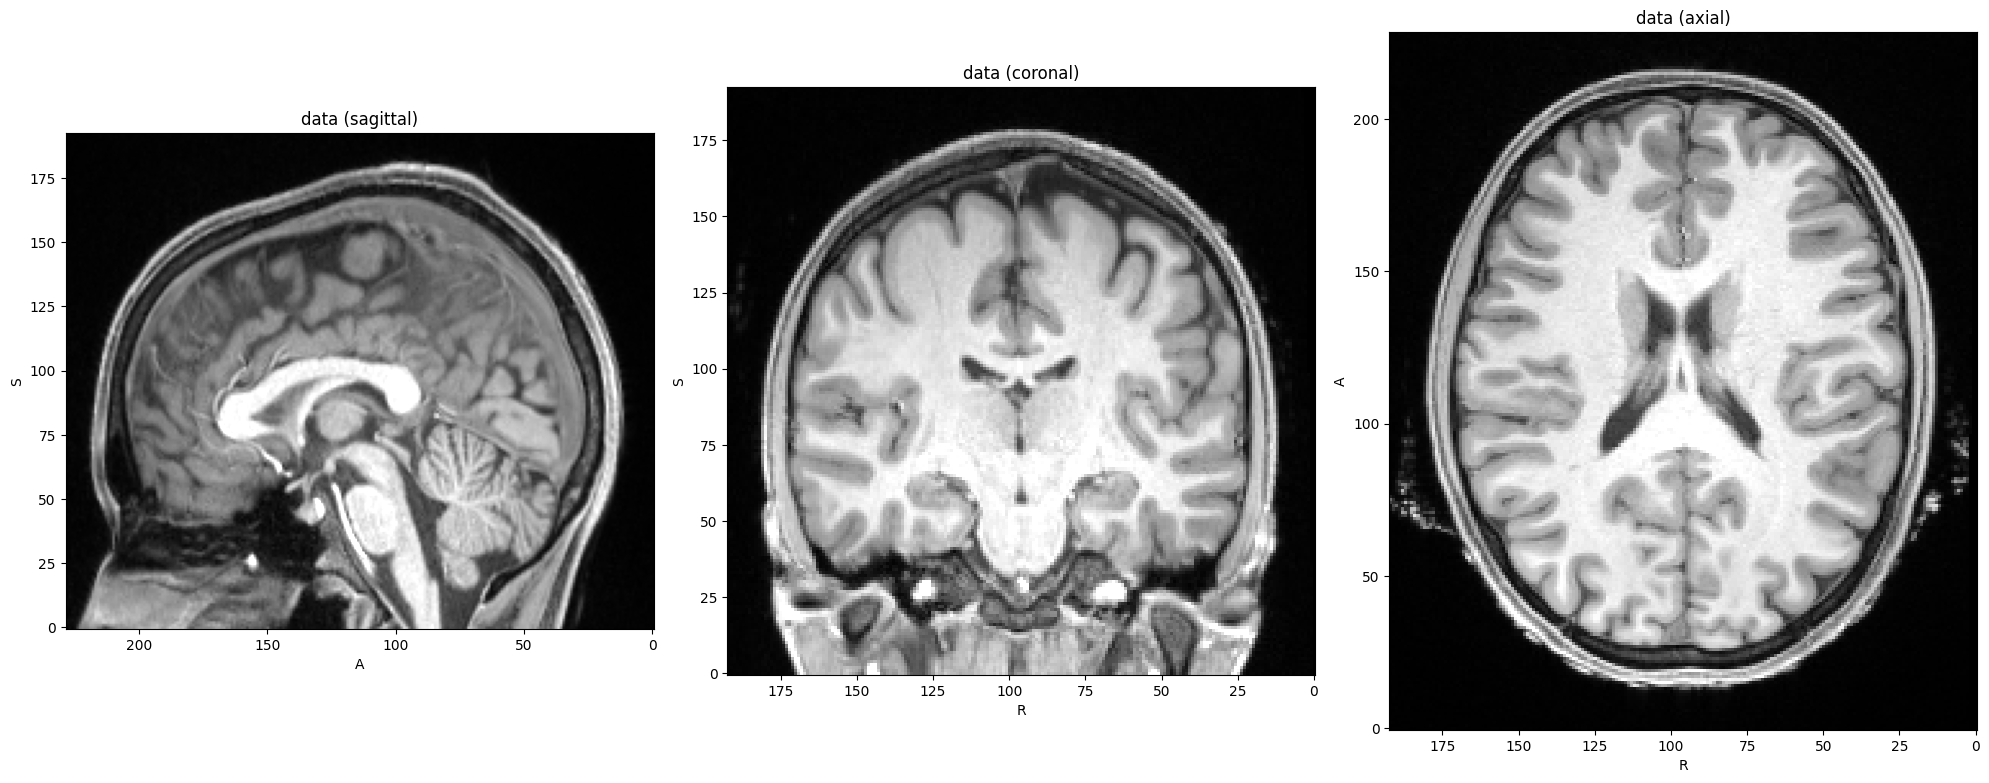

In [22]:
newp = Compose(
    [
        LoadImaged(keys="data", ensure_channel_first=True, image_only=True),
        Orientationd(keys="data", axcodes="RAS"),
        ScaleIntensityd(keys="data", minv=0, maxv=1),
    ]
)
unp = newp(
    {
        "data": r"C:\Users\Brico\Code\Master\mrart\data_test\ampscz\clear\sub-MT03607_ses-202212291_rec-norm_run-1_space-MNI152NLin2009cSym_res-1x1x1_T1w.nii.gz",
        "sub_id":"test",
        "ses_id":"test",
    }
)
unp["data"].max(), unp["data"].min()
base_sub = Subject(data=tio.ScalarImage(tensor=unp['data']))
base_sub.plot(figsize=(20,20))

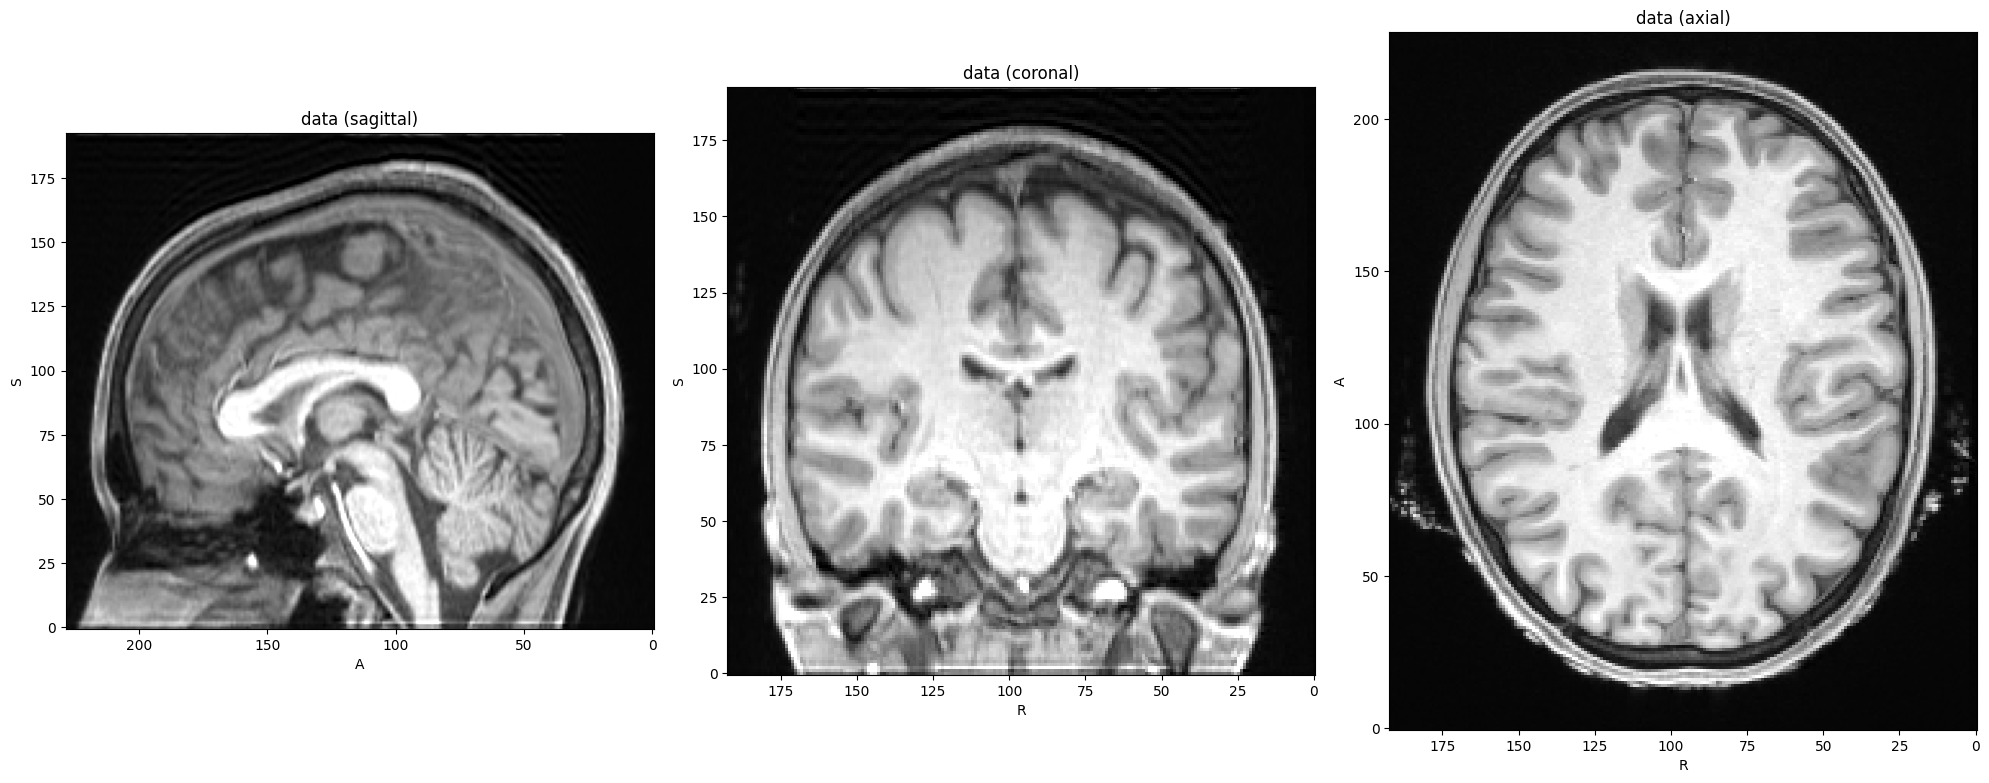

{'data': tensor([[[[ 5.9672e-05, -3.6541e-04,  3.1544e-04,  ..., -1.0662e-04,
            -1.9307e-05,  1.3621e-04],
           [ 4.7260e-05, -3.5274e-04,  3.4781e-04,  ..., -7.7431e-05,
            -1.9034e-05,  1.2384e-04],
           [ 5.0824e-05, -3.0288e-04,  3.6875e-04,  ..., -4.6272e-05,
            -4.7526e-05,  1.0190e-04],
           ...,
           [ 1.8579e-04, -3.3544e-04,  2.4961e-04,  ...,  2.8024e-05,
            -2.3945e-05, -3.6778e-05],
           [ 2.5744e-04, -3.7676e-04,  1.0634e-04,  ..., -2.9340e-05,
            -1.4069e-04,  6.0749e-05],
           [ 1.1677e-04, -6.0192e-04,  8.6204e-04,  ..., -2.1446e-05,
            -6.9171e-05,  1.1949e-04]],
 
          [[ 1.4983e-03,  1.1941e-03,  3.1769e-03,  ..., -1.8433e-04,
             2.1677e-05,  8.6744e-04],
           [ 2.2920e-03,  2.2617e-03,  4.6152e-03,  ..., -3.0719e-04,
            -2.6973e-05,  1.1349e-03],
           [ 2.0997e-03,  2.3387e-03,  4.0843e-03,  ..., -3.4047e-04,
             3.2664e-05,  1.019

In [28]:
synth = CreateSynthVolume()(unp)
sub_synth = Subject(data=tio.ScalarImage(tensor=synth['data']))
sub_synth.plot(figsize=(20,20))
synth

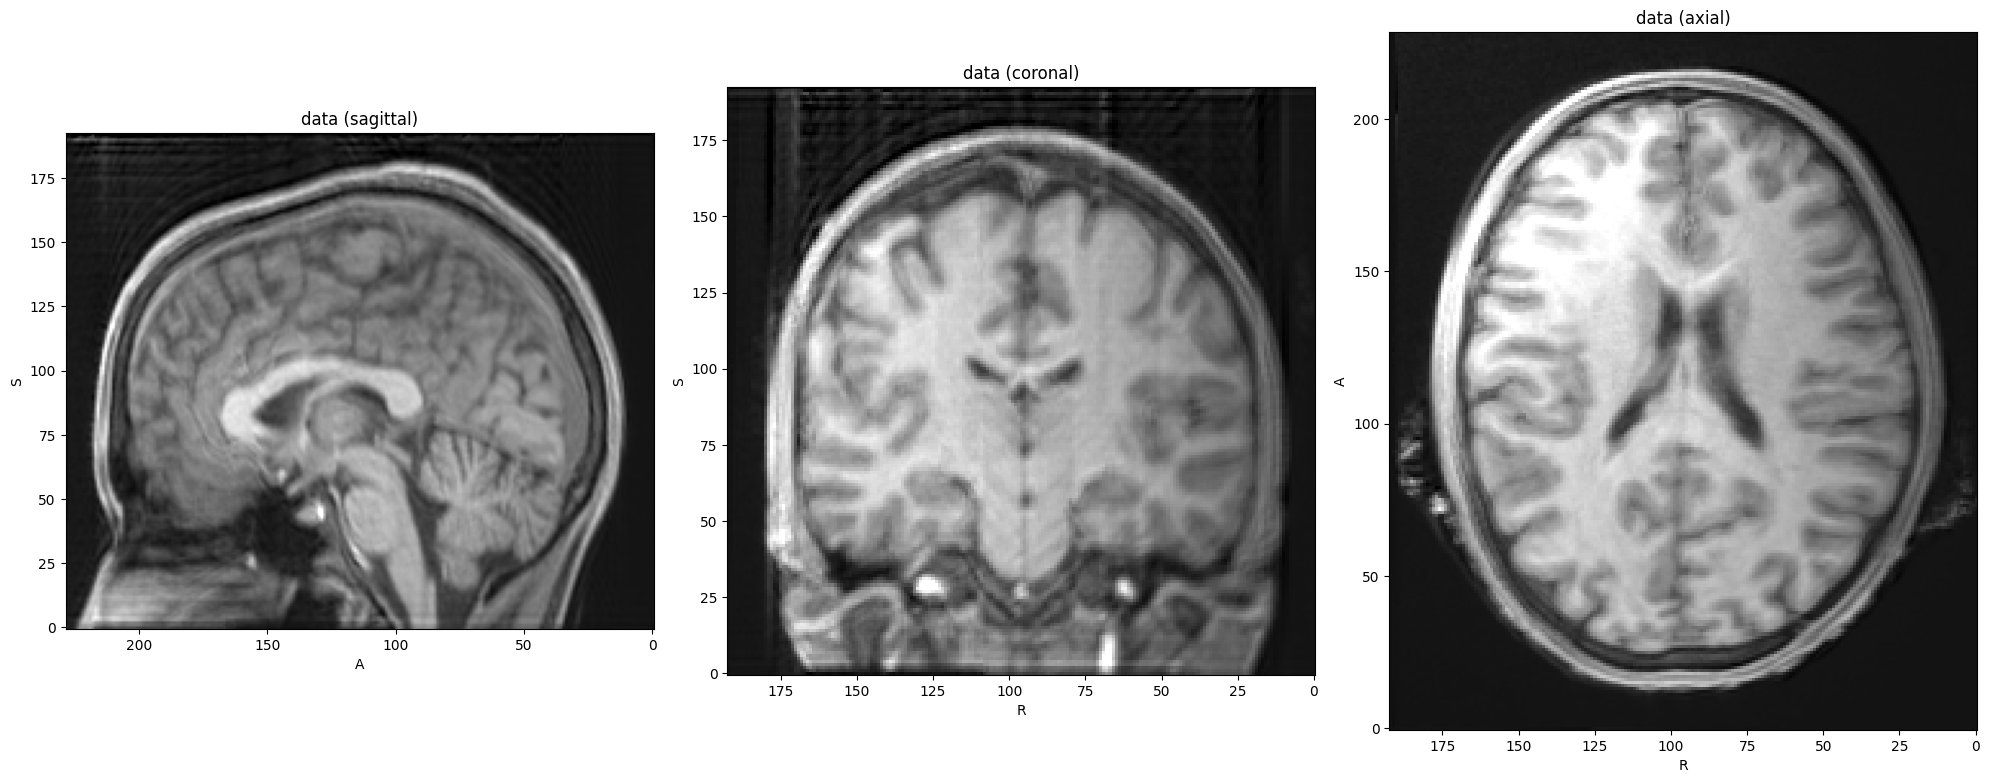

{'data': tensor([[[[ 3.5836e-04,  5.7057e-04,  2.9423e-04,  ..., -5.4482e-05,
            -1.3521e-03, -4.2797e-04],
           [ 8.5828e-04, -4.9483e-04,  9.7522e-04,  ...,  4.6785e-03,
             7.8706e-03, -1.4784e-02],
           [ 1.3206e-03, -1.1524e-05,  5.2278e-04,  ...,  6.5070e-03,
             1.2996e-02, -2.2364e-02],
           ...,
           [ 2.6712e-03,  1.9154e-03,  7.0651e-04,  ...,  2.3335e-02,
            -9.6102e-03, -1.8498e-02],
           [ 2.6862e-03,  1.8034e-03,  5.2153e-04,  ...,  2.5340e-02,
            -9.2372e-03, -1.8981e-02],
           [ 2.6971e-03,  1.8039e-03,  8.0311e-04,  ...,  2.5860e-02,
            -8.8130e-03, -1.8638e-02]],
 
          [[ 1.2319e-03,  8.4626e-04,  5.2178e-04,  ..., -3.9845e-03,
             4.8867e-03, -4.1487e-03],
           [ 1.1872e-03, -5.0479e-05,  1.3599e-03,  ...,  5.3518e-03,
             8.7388e-03, -1.3909e-02],
           [ 1.4896e-03,  2.1548e-04,  9.3027e-04,  ...,  5.6971e-03,
             1.4880e-02, -2.147

In [47]:
synth = CreateSynthVolume()(unp)
sub_synth = Subject(data=tio.ScalarImage(tensor=synth['data']))
sub_synth.plot(figsize=(20,20))
synth

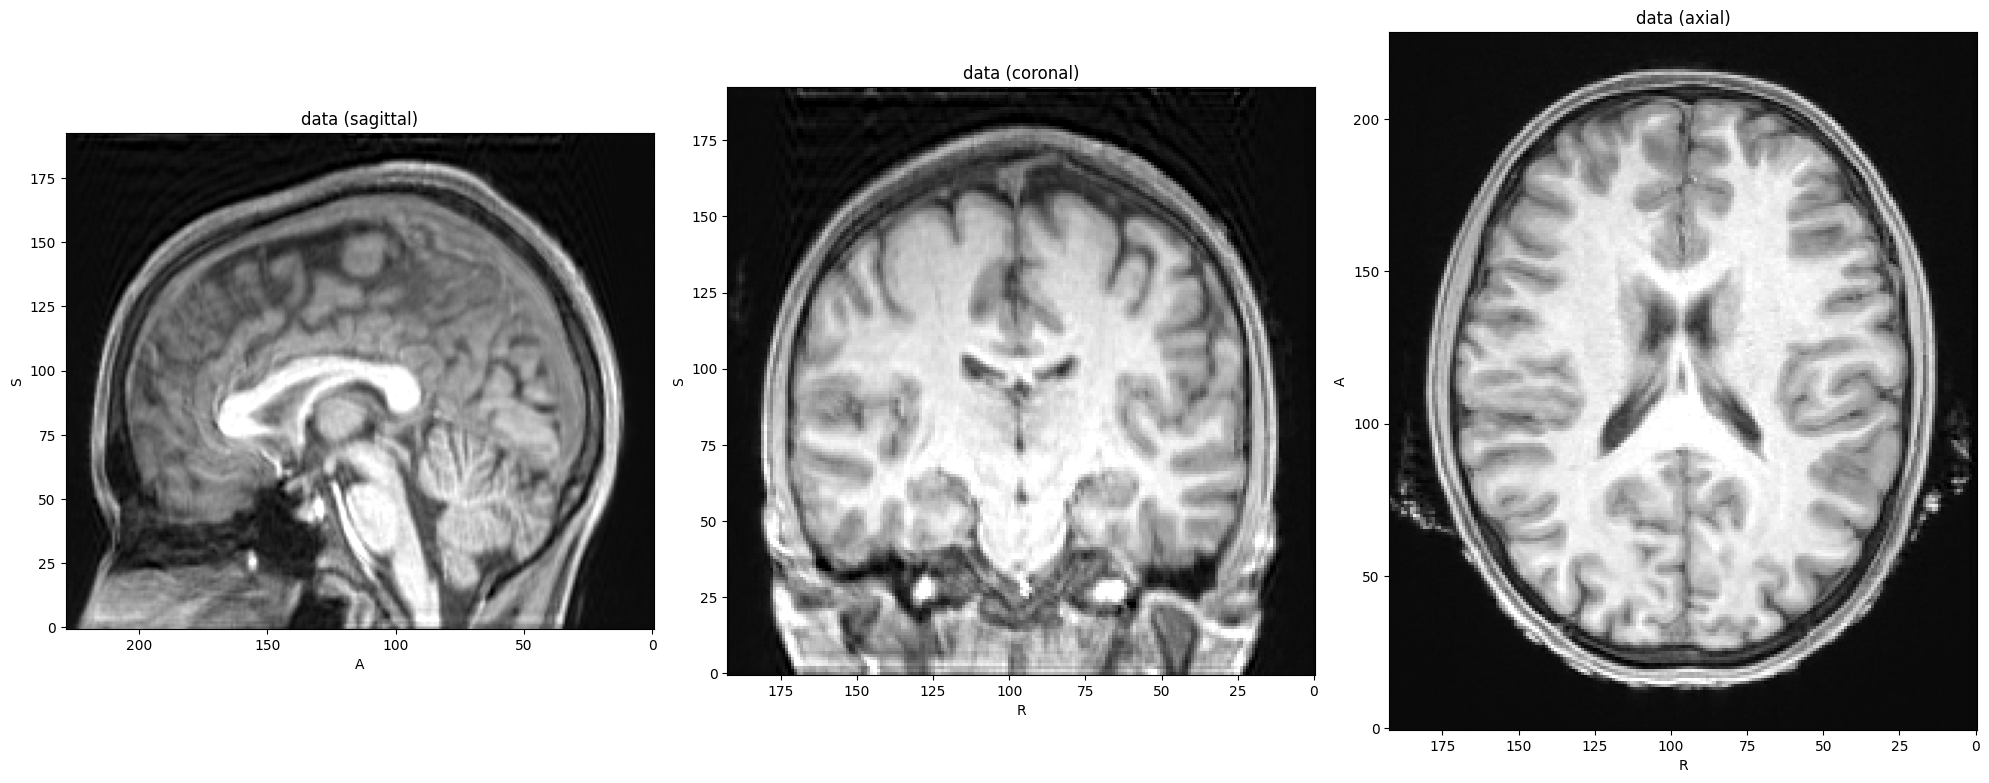

In [13]:
sub = Subject(data=tio.ScalarImage(tensor=unp['data']))
cm = RandomMotion(image_interpolation="bspline", num_transforms=6, degrees=1, translation=0.5)
motionned:Subject = cm(sub)
motionned.plot(figsize=(20,20))

c:\Users\Brico\miniconda3\envs\bowl\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\Brico\miniconda3\envs\bowl\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


940

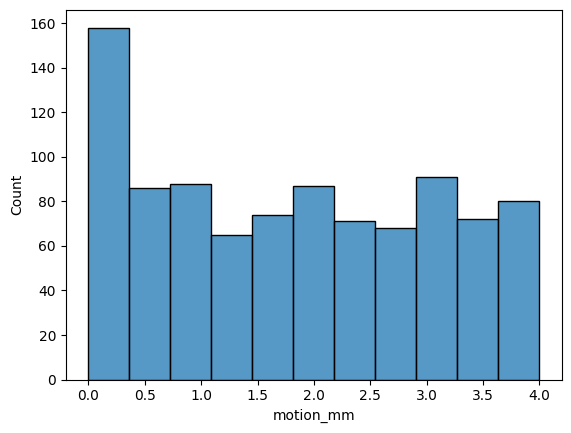

In [48]:
val_analysis = pd.read_csv(r"C:\Users\Brico\Downloads\val(13).csv")
sb.histplot(val_analysis, x="motion_mm")
len(val_analysis)

c:\Users\Brico\miniconda3\envs\bowl\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\Brico\miniconda3\envs\bowl\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: xlabel='ssim_loss', ylabel='Count'>

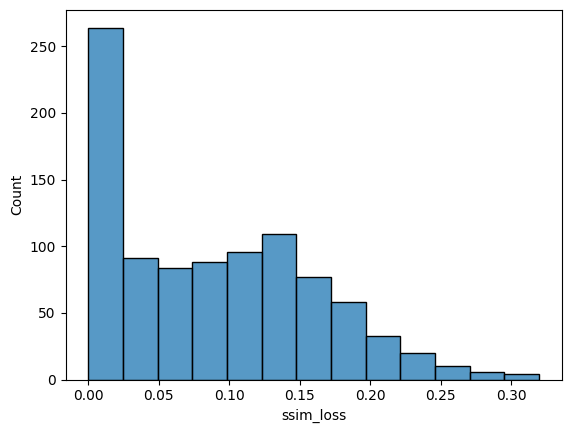

In [50]:
sb.histplot(val_analysis, x="ssim_loss")


c:\Users\Brico\miniconda3\envs\bowl\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\Brico\miniconda3\envs\bowl\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\Brico\miniconda3\envs\bowl\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: xlabel='motion_binary', ylabel='Count'>

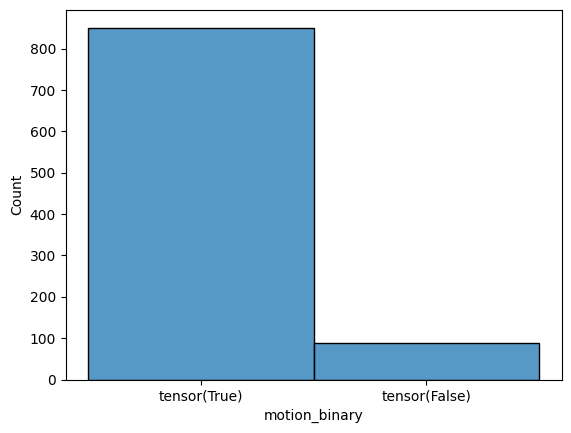

In [52]:
sb.histplot(val_analysis, x="motion_binary")